In [2]:
#This notebook uses forced-alginment HMMs to label ALL datasets and BOTH of the 
#train/test partitions ('HeldOutBlocks' and 'HeldOutTrials').

#For a walkthrough of how the data labeling step works see 'Step2_hmmDataLabeling_walkthrough', which steps 
#through a single example sentence while visualizing the key variables.

In [3]:
import numpy as np
import scipy.io
from characterDefinitions import getHandwritingCharacterDefinitions
from dataLabelingStep import labelDataset, constructRNNTargets
import os
import datetime

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#define which datasets to process
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

#defines the list of all 31 characters and what to call them
charDef = getHandwritingCharacterDefinitions()

#saves all labels in this folder
# if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step2_HMMLabels'):
#     os.mkdir(rootDir + 'RNNTrainingSteps/Step2_HMMLabels')

In [4]:
def load_data(dir_load, fileName_load, path_load=None):
    from pathlib import Path
    import scipy.io
    if path_load is None:
        dir_load = Path(dir_load).resolve()
        fileName_load = fileName_load
        path_load = dir_load / fileName_load

    dat = scipy.io.loadmat(path_load)
    return dat

In [5]:
dataDir = dataDirs[0]

In [6]:
# for dataDir in dataDirs:
timeStart = datetime.datetime.now()
print('Labeling ' + dataDir + ' dataset')

#load sentences, single letter, time-warped files, and train/test partitions
#     sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/sentences.mat')
#     singleLetterDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/singleLetters.mat')
#     twCubes = scipy.io.loadmat(rootDir+'RNNTrainingSteps/Step1_TimeWarping/'+dataDir+'_warpedCubes.mat')
sentenceDat = load_data(dir_load=r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir,
                       fileName_load=r'sentences.mat')
singleLetterDat = load_data(dir_load=r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir,
                       fileName_load=r'singleLetters.mat')
twCubes = load_data(dir_load=r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/'+dataDir,
                       fileName_load=dataDir+r'_warpedCubes.mat')

cvPart_heldOutBlocks = scipy.io.loadmat(r'/media/rich/bigSSD/NMA_data/Willet_data/RNNTrainingSteps/trainTestPartitions_HeldOutBlocks.mat')
cvPart_heldOutTrials = scipy.io.loadmat(r'/media/rich/bigSSD/NMA_data/Willet_data/RNNTrainingSteps/trainTestPartitions_HeldOutTrials.mat')
cvParts = [cvPart_heldOutBlocks, cvPart_heldOutTrials]

#the last two sessions have hashmarks (#) to indicate that T5 should take a brief pause
#here we remove these from the sentence prompts, otherwise the code below will get confused (because # isn't a character)
for x in range(sentenceDat['sentencePrompt'].shape[0]):
    sentenceDat['sentencePrompt'][x,0][0] = sentenceDat['sentencePrompt'][x,0][0].replace('#','')

cvFolderNames = ['HeldOutBlocks', 'HeldOutTrials']

sentences = sentenceDat['sentencePrompt'][:,0]
sentenceLens = sentenceDat['numTimeBinsPerSentence'][:,0]

#construct separate labels for each training partition
for cvPart, cvFolder in zip(cvParts, cvFolderNames):
    print("Labeling '" + cvFolder + "' partition")
    trainPartitionIdx = cvPart[dataDir+'_train']
    testPartitionIdx = cvPart[dataDir+'_test']

    #label the data with an iterative forced alignmnet HMM
    letterStarts, letterDurations, blankWindows = labelDataset(sentenceDat, 
                                                               singleLetterDat, 
                                                               twCubes,
                                                               trainPartitionIdx, 
                                                               testPartitionIdx, 
                                                               charDef)

    #construct targets for supervised learning
    charStartTarget, charProbTarget, ignoreErrorHere = constructRNNTargets(letterStarts, 
                                                                           letterDurations, 
                                                                           sentenceDat['neuralActivityCube'].shape[1], 
                                                                           sentences, 
                                                                           charDef)

    saveDict = {}
    saveDict['letterStarts'] = letterStarts
    saveDict['letterDurations'] = letterDurations
    saveDict['charStartTarget'] = charStartTarget.astype(np.float32)
    saveDict['charProbTarget'] = charProbTarget.astype(np.float32)
    saveDict['ignoreErrorHere'] = ignoreErrorHere.astype(np.float32)
    saveDict['blankWindows'] = blankWindows
    saveDict['timeBinsPerSentence'] = sentenceDat['numTimeBinsPerSentence']

#         if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step2_HMMLabels/'+cvFolder):
#             os.mkdir(rootDir + 'RNNTrainingSteps/Step2_HMMLabels/'+cvFolder)

#         scipy.io.savemat(rootDir + 'RNNTrainingSteps/Step2_HMMLabels/'+cvFolder+'/'+dataDir+'_timeSeriesLabels.mat', saveDict)

timeEnd = datetime.datetime.now()
print('Total time taken: ' + str((timeEnd - timeStart).total_seconds()) + ' seconds')
print(' ')


Labeling t5.2019.05.08 dataset
Labeling 'HeldOutBlocks' partition
HMM Iteration 0
HMM Iteration 1
Labeling 'HeldOutTrials' partition
HMM Iteration 0
HMM Iteration 1
Total time taken: 1275.516326 seconds
 


In [38]:
charProbTarget.shape

(102, 10669, 31)

In [40]:
sentences[0]

array(['thanks>so>much,>honey~'], dtype='<U22')

<IPython.core.display.Javascript object>


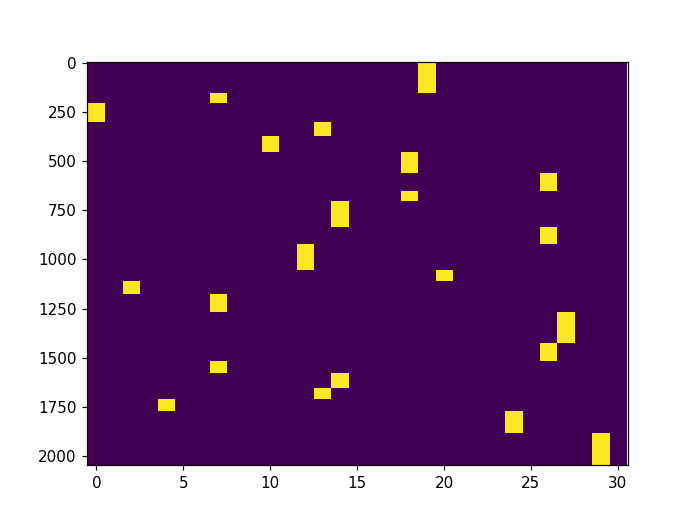

In [39]:
plt.figure()
plt.imshow(charProbTarget[0], aspect='auto', interpolation='none')

In [9]:
saveDict.keys()

dict_keys(['letterStarts', 'letterDurations', 'charStartTarget', 'charProbTarget', 'ignoreErrorHere', 'blankWindows', 'timeBinsPerSentence'])

In [7]:
sentenceDat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'neuralActivityCube', 'sentencePrompt', 'intendedText', 'numTimeBinsPerSentence', 'sentenceCondition', 'sentenceBlockNums', 'excludedSentences', 'neuralActivityTimeSeries', 'clockTimeSeries', 'blockNumsTimeSeries', 'blockList', 'blockStartDates', 'goCueOnsetTimeBin', 'delayCueOnsetTimeBin', 'sentenceEndTimeBin', 'arrayGeometryMap', 'rnn_charProbTimeSeries', 'rnn_newCharTimeSeries', 'rnn_decodedCharTimes', 'rnn_decodedText', 'rnn_charMapASCII'])

In [8]:
sentenceDat['neuralActivityCube'].shape

(102, 10669, 192)

In [9]:
sentenceDat['sentencePrompt'][0]

array([array(['thanks>so>much,>honey~'], dtype='<U22')], dtype=object)

In [10]:
sentenceDat['rnn_decodedCharTimes']

array([], shape=(0, 0), dtype=int32)

In [11]:
np.sum(letterStarts>0, axis=1)

array([ 22,  65,  20,  62,  17,  64,  42,  37,  92,  25,  84,  45,  82,
        84,  25,  46,  55,   0,  32,  70,  68,  62,  34,  41,  63,  42,
        18,  34,  50,  21,  41,   0,  59,  99,  81,  78,  23,  61,  33,
        84,  32,  57,  67,  69,  35,  51,  46,  81,  37,  91,  54,  69,
       114,  62,  75,  59,  69,  73,  86,  77,  98,   0,  61,  70,  71,
        29,  47,  87,  42,  18,  39,  67,  33,  33,  50,  51,  32,  54,
        52,  48,  45, 105,  78,  56,  52,  27,  35,  46,  84, 105,  38,
        99,  25,  83,  67,  29,  45,  78,  71,  65, 112,  65])

<IPython.core.display.Javascript object>


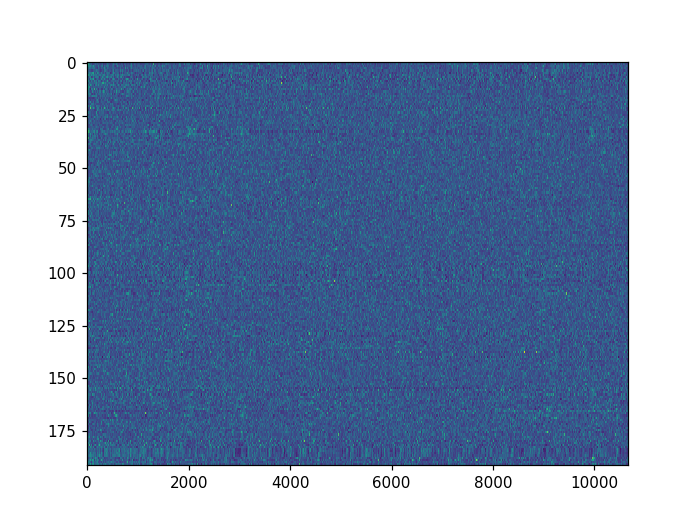

In [12]:
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats

%matplotlib notebook

plt.figure()
plt.imshow(scipy.signal.savgol_filter(scipy.stats.zscore(sentenceDat['neuralActivityCube'][0], axis=0), 21, 3, axis=0).T, 
           aspect='auto',
           interpolation='none')

In [13]:
sentenceDat['neuralActivityCube'].shape

(102, 10669, 192)

In [20]:
sentenceDat['neuralActivityTimeSeries'].shape

(599319, 192)

In [14]:
letterStarts[0]

array([  44.,  159.,  209.,  304.,  374.,  459.,  564.,  654.,  704.,
        839.,  924., 1054., 1114., 1179., 1269., 1429., 1519., 1579.,
       1654., 1709., 1774., 1884.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

In [24]:
from sklearn.decomposition import PCA

X = scipy.signal.savgol_filter(scipy.stats.zscore(sentenceDat['neuralActivityCube'][0][:2000,:], axis=0), 9, 3, axis=0).T
pca = PCA(n_components=10)
pca.fit(X)

PCA(n_components=10)

In [25]:
pca.components_.shape

(10, 2000)

<IPython.core.display.Javascript object>


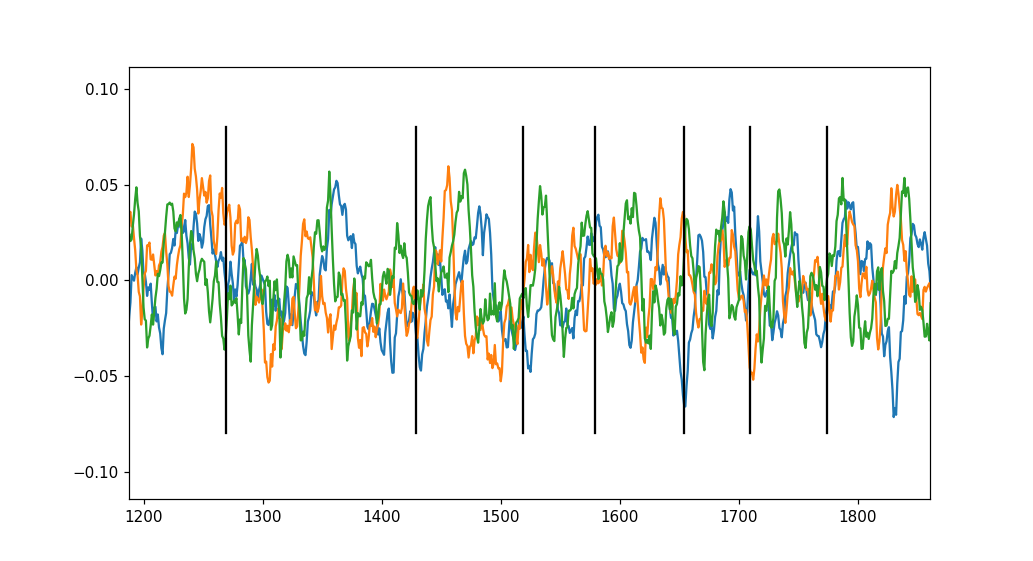

In [29]:
plt.figure()
plt.plot(pca.components_[0:3].T)
for ii in range(len(letterStarts[0])):
    plt.plot(np.array([letterStarts[0][ii], letterStarts[0][ii]]), np.array([-0.08,0.08]), 'k')